In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split


# Ścieżki do katalogów z danymi
paths = [
    "chest_xray/train/NORMAL", "chest_xray/train/PNEUMONIA",
    "chest_xray/test/NORMAL", "chest_xray/test/PNEUMONIA",
    "chest_xray/val/NORMAL", "chest_xray/val/PNEUMONIA"
]

list_total = []

for path in paths:
    # Ustalenie etykiety na podstawie nazwy katalogu
    label = 0 if "NORMAL" in path else 1
    # Przejście przez wszystkie pliki w danym katalogu
    for img in os.listdir(path):
        # Pełna ścieżka do pliku
        full_path = os.path.join(path, img)
        # Dodanie ścieżki i etykiety do listy
        list_total.append([full_path, label])

# Przykładowe wyświetlenie pierwszych 5 elementów listy
print(list_total[:5])

[['chest_xray/train/NORMAL\\IM-0115-0001.jpeg', 0], ['chest_xray/train/NORMAL\\IM-0117-0001.jpeg', 0], ['chest_xray/train/NORMAL\\IM-0119-0001.jpeg', 0], ['chest_xray/train/NORMAL\\IM-0122-0001.jpeg', 0], ['chest_xray/train/NORMAL\\IM-0125-0001.jpeg', 0]]


In [2]:
# Tworzymy DataFrame
df_total = pd.DataFrame(list_total, columns=['image', 'label'])

# Mieszamy dane
df_total = df_total.sample(frac=1)

# Dzielimy na podzbiory
X_total = df_total['image']
y_total = df_total['label']

X_train, X_temp, y_train, y_temp = train_test_split(X_total, y_total, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f'Liczebność zbioru treningowego: {len(X_train)}')
print(f'Liczebność zbioru testowego: {len(X_test)}')
print(f'Liczebność zbioru walidacyjnego: {len(X_val)}')

Liczebność zbioru treningowego: 4099
Liczebność zbioru testowego: 879
Liczebność zbioru walidacyjnego: 878


In [3]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definicja generatora augmentacji danych
data_gen = ImageDataGenerator(
    rotation_range=10,  # rotacja do 10 stopni
    width_shift_range=0.1,  # przesunięcie w osi X do 10% szerokości
    height_shift_range=0.1,  # przesunięcie w osi Y do 10% wysokości
    shear_range=0.1,  # ścinanie do 10%
    zoom_range=0.1,  # przybliżenie do 10%
    horizontal_flip=True,  # odwrócenie w poziomie (jak w lustrze)
    fill_mode='nearest',  # tryb wypełniania brakujących pikseli
    brightness_range=[0.8,1.2],  # zakres zmian jasności
)


def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0
    img = np.reshape(img, (256, 256, 1))
    img = data_gen.random_transform(img)
    
    return img

def compose_dataset(X, y):
    data = []
    labels = []
    
    for img_path, label in zip(X, y):
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

# Przygotowanie danych
X_train, y_train = compose_dataset(X_train, y_train)
X_test, y_test = compose_dataset(X_test, y_test)
X_val, y_val = compose_dataset(X_val, y_val)

Typ X_val: <class 'numpy.ndarray'>
Typ y_val: <class 'numpy.ndarray'>
Kształt X_val: (878, 256, 256, 1)
Kształt y_val: (878,)
Maksymalny indeks w y_val: 1
Rozmiar X_val: 878
Pierwsze 5 etykiet w y_val: [0 1 1 0 1]
Pierwszy obraz w X_val: [[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
Zbalansowanie klas w y_val: {0: 209, 1: 669}
(4099, 2)
(418, 2)


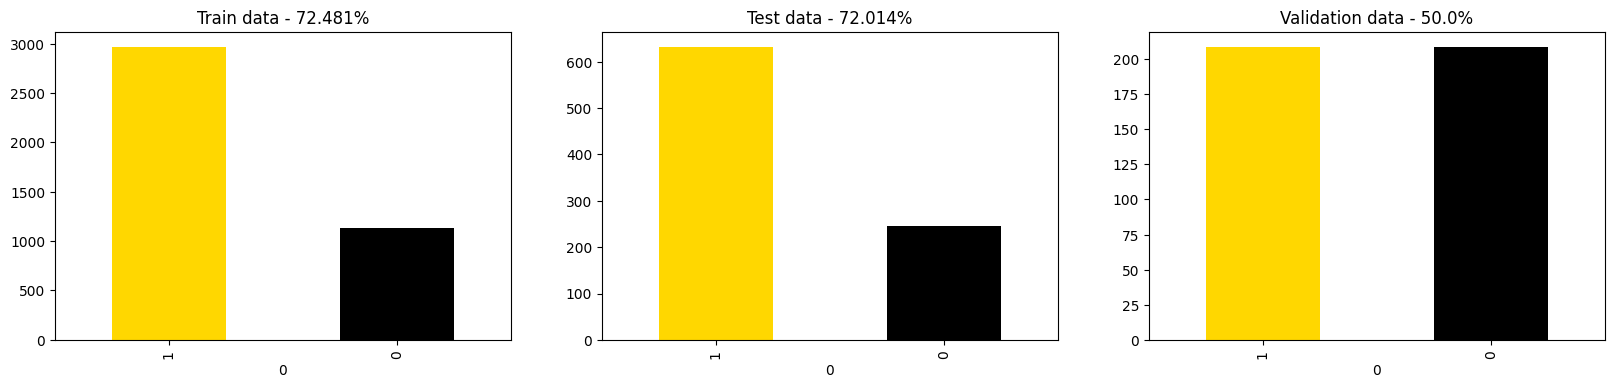

In [4]:
from tensorflow.keras.utils import to_categorical

#Balansowanie zbioru walidacyjnego
import numpy as np
from sklearn.utils import shuffle


# Sprawdź typy danych
print(f"Typ X_val: {type(X_val)}")
print(f"Typ y_val: {type(y_val)}")

# Sprawdź kształt tablic
print(f"Kształt X_val: {X_val.shape}")
print(f"Kształt y_val: {y_val.shape}")

# Zakładając, że y_val zawiera etykiety jako pojedynczą kolumnę
# Sprawdź zakres indeksów
print(f"Maksymalny indeks w y_val: {y_val.max()}")
print(f"Rozmiar X_val: {X_val.shape[0]}")

# Upewnij się, że zakres indeksów jest poprawny
assert y_val.max() < X_val.shape[0], "Indeks jest poza zakresem!"

# Sprawdź zawartość tablic
print("Pierwsze 5 etykiet w y_val:", y_val[:5])
print("Pierwszy obraz w X_val:", X_val[0])

# Sprawdź zbalansowanie klas
unique, counts = np.unique(y_val, return_counts=True)
print("Zbalansowanie klas w y_val:", dict(zip(unique, counts)))


def balance_validation_set(X, y):
    # Znajdź indeksy dla każdej klasy
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]
    
    # Upewnij się, że nie próbujesz wybrać więcej przykładów niż istnieje
    n_samples = min(len(class_0_indices), len(class_1_indices))
    
    # Zbalansuj klasy
    np.random.seed(0) # Ustaw seed dla powtarzalności
    class_0_indices_balanced = np.random.choice(class_0_indices, size=n_samples, replace=False)
    class_1_indices_balanced = np.random.choice(class_1_indices, size=n_samples, replace=False)
    
    # Połącz indeksy i przetasuj
    balanced_indices = np.concatenate((class_0_indices_balanced, class_1_indices_balanced))
    balanced_indices = shuffle(balanced_indices, random_state=0)
    
    # Zastosuj indeksy do X i y
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    
    return X_balanced, y_balanced

# Użyj funkcji do zbalansowania zbioru walidacyjnego
X_val_balanced, y_val_balanced = balance_validation_set(X_val, y_val)

#Konwersja etykiet na format kategoryczny
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val_balanced = to_categorical(y_val_balanced)
print(y_train.shape)
print(y_val_balanced.shape)

import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

# Wykres dla zbioru treningowego
# Wykres dla zbioru treningowego
plt.subplot(1,3,1)
pd.DataFrame(y_train.argmax(axis=1))[0].value_counts().plot(kind='bar', color=['gold','black'])
percentage_of_class_1 = 100 * np.sum(y_train[:, 1]) / len(y_train)
plt.title(f'Train data - {round(percentage_of_class_1, 3)}%')

# Wykres dla zbioru testowego
plt.subplot(1,3,2)
pd.DataFrame(y_test.argmax(axis=1))[0].value_counts().plot(kind='bar', color=['gold','black'])
percentage_of_class_1_test = 100 * np.sum(y_test[:, 1]) / len(y_test)
plt.title(f'Test data - {round(percentage_of_class_1_test, 3)}%')

# Wykres dla zbioru walidacyjnego
plt.subplot(1,3,3)
pd.DataFrame(y_val_balanced.argmax(axis=1))[0].value_counts().plot(kind='bar', color=['gold','black'])
percentage_of_class_1_val = 100 * np.sum(y_val_balanced[:, 1]) / len(y_val_balanced)
plt.title(f'Validation data - {round(percentage_of_class_1_val, 3)}%')
plt.show()

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Inicjalizacja modelu
model = Sequential()

# Pierwsza grupa warstw konwolucyjnych
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(256, 256, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Druga grupa warstw konwolucyjnych
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Trzecia grupa warstw konwolucyjnych
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Warstwa gęsta
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
# model.add(Dense(1, activation='sigmoid'))


# Kompilacja modelu dla problemu binarnego
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

# Callback do wczesnego zatrzymywania
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Podsumowanie modelu
model.summary()

c:\Users\pklyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,461,682 (32.28 MB)

 Trainable params: 8,461,234 (32.28 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
# Trening modelu
history = model.fit(
    X_train, y_train,
    epochs=50,  # Maksymalna liczba epok
    batch_size=32,  # Rozmiar batcha
    validation_data=(X_val_balanced, y_val_balanced),
    callbacks=[early_stopping]  # Użycie wcześniej zdefiniowanego callbacku
)

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 116s 873ms/step - accuracy: 0.6554 - loss: 4.5197 - val_accuracy: 0.5000 - val_loss: 1.4149
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 113s 878ms/step - accuracy: 0.7270 - loss: 2.7800 - val_accuracy: 0.5048 - val_loss: 20.8960
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 112s 872ms/step - accuracy: 0.7152 - loss: 1.0938 - val_accuracy: 0.5048 - val_loss: 33.3814
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 114s 882ms/step - accuracy: 0.7244 - loss: 0.6343 - val_accuracy: 0.5048 - val_loss: 45.6985
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 112s 869ms/step - accuracy: 0.7263 - loss: 0.6262 - val_accuracy: 0.4976 - val_loss: 104.3347
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 114s 884ms/step - accuracy: 0.7366 - loss: 0.6062 - val_accuracy: 0.4976 - val_loss: 161.0750
Epoch 6: early stopping
